In [ ]:
!gdown https://drive.google.com/uc?id=1SOLPeiKwpIf3ZgYyR8zpqJXi3bYse35F
!gdown https://drive.google.com/uc?id=1snmXlD2qOiEy3-btwmA6Ru6R-tLDI8qe

Downloading...
From: https://drive.google.com/uc?id=1SOLPeiKwpIf3ZgYyR8zpqJXi3bYse35F
To: /content/Test-20231102T160652Z-001.zip
100% 4.47M/4.47M [00:00<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1snmXlD2qOiEy3-btwmA6Ru6R-tLDI8qe
To: /content/Train-20231104T185002Z-001.zip
100% 54.9M/54.9M [00:00<00:00, 155MB/s]


In [ ]:
!unzip /content/Test-20231102T160652Z-001.zip
!unzip /content/Train-20231104T185002Z-001.zip

Archive:  /content/Test-20231102T160652Z-001.zip
replace Test/D_test/D574.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##**IMPORTAR BIBLIOTECAS**

In [ ]:
# OS se usa para que las carpetas y los directorios interactúen en el sistema operativo
import os
import random
import numpy as np
import pandas as pd
# Estas líneas de código se utilizan para visualizar los datos
import matplotlib.pyplot as plt
%matplotlib inline

# Biblioteca para tareas de visión por computadora y procesamiento de imágenes, incluida la detección de objetos
import cv2
# Colección de algoritmos para el procesamiento de imágenes. Proporciona herramientas para la segmentación de imágenes, filtrado, etc
import skimage
# Se utiliza para la transformación de imágenes, como el cambio de tamaño y manipulaciones geométricas
from skimage.transform import resize

# Tensorflow se utiliza para construir y entrenar modelos de deep learning
# Keras es una API de red neuronal de alto nivel. Simplifica el proceso de construir y entrenar redes neuronales
import tensorflow as tf
from tensorflow import keras
# Esta API a continuación proporciona utilidades para tareas como la codificación one-hot de etiquetas (to_categorical)
from tensorflow.keras.utils import to_categorical
# Puede crear capas de modelos de redes neuronales, apiladas una encima de la otra, de forma secuencial
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


# Convo2D se utiliza para el procesamiento de imágenes
# MaxPooling2D se utiliza en las redes neuronales convolucionales (CNN) para reducir el tamaño de los mapas de características
# La activación es como un filtro que hace que tu red neuronal sea más flexible y capaz de reconocer patrones complejos
# La capa densa mantiene las neuronas cerca unas de otras para tomar decisiones importantes basadas en lo que la red ha aprendido
# Flatten aplana los datos estructurados para que la red pueda entenderlos y analizarlos fácilmente
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
# Detiene la red neuronal cuando la métrica del modelo ha dejado de mejorar
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

## **CREAR DIRECTORIOS PARA TEST Y TRAIN**



In [ ]:
train_dir = '/content/Train'
test_dir = '/content/Test'

## **REDIMENSIONAR LAS IMÁGENES A TAMAÑO 224X224/CAMBIAR A ESCALA DE GRISES**

In [ ]:
batch_size = 32
imageSize = 224
target_dims = (imageSize, imageSize, 1)
num_classes = 29
train_len = 87000

# Crear un diccionario para los nombres de las distintas clases que tenemos
label_map = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
}

def load_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return None
    img = skimage.transform.resize(img, (imageSize, imageSize, 1))
    return img

def get_data(folder, label_map):
    X = []
    y = []

    for folderName in os.listdir(folder):
        if folderName not in label_map:
            continue  # Omitir las carpetas que no estén en el mapa de clases
        label = label_map[folderName]

        folder_path = os.path.join(folder, folderName)

        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            img = load_image(image_path)

            if img is not None:
                X.append(img)
                y.append(label)

    return np.array(X), np.array(y)

X_train, y_train = get_data(train_dir, label_map)
print("Images successfully imported...")


Images successfully imported...


> **COMPROBAR QUE LOS DATOS SE HAN PROCESADO CORRECTAMENTE**


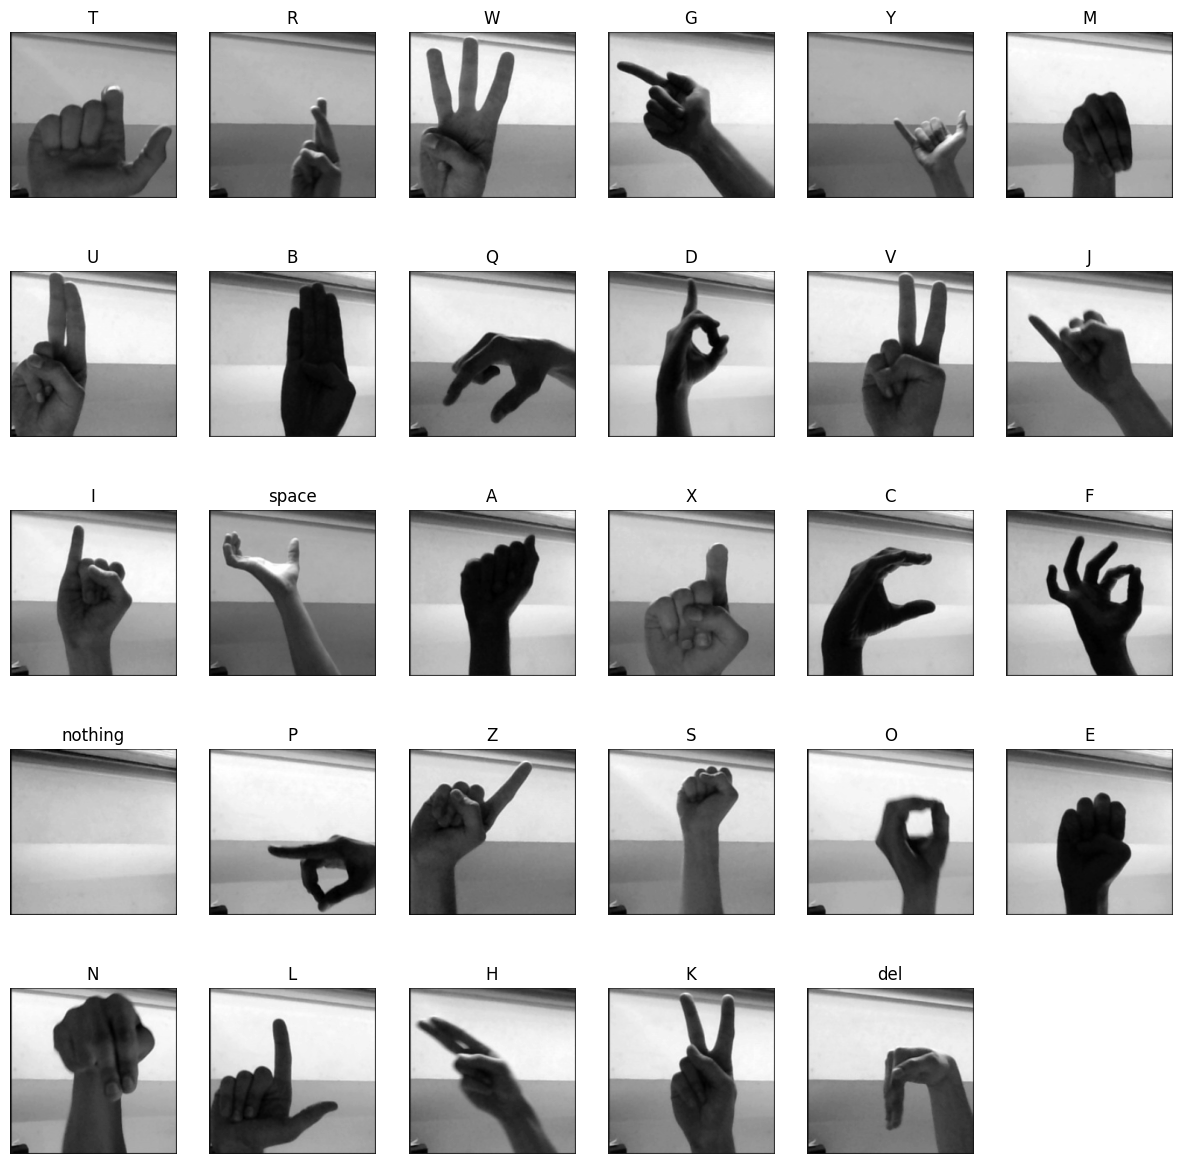

In [ ]:
# Función para cargar y mostrar imágenes únicas desde el directorio de entrenamiento
def load_and_display_unique_images():
    image_size = (224, 224)
    unique_images = []  # Lista para guardar las imágenes únicas
    unique_labels = []  # Lista para guardar lsa clases correspondientes

    # Ahora iteramos con las distintas carpetas en el directorio de train
    for folder in os.listdir(train_dir):
        for file in os.listdir(os.path.join(train_dir, folder)):
            file_path = os.path.join(train_dir, folder, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Leer la imagen en escala de grises
            final_image = cv2.resize(image, image_size)

            # Agregar la imagen única y su etiqueta
            unique_images.append(final_image)
            unique_labels.append(folder)
            break  # Ponemso un "break" para que solo se cargue una imagen por categoría

    return unique_images, unique_labels

# Cargar las imágenes únicas con sus clases correspondientes
unique_images, unique_labels = load_and_display_unique_images()

# Mostrar las imágenes con sus clases en una cuadrícula
fig = plt.figure(figsize=(15, 15))
def plot_image(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image, cmap='gray')  # Usar cmap='gray' para mostrar imágenes en escala de grises
    plt.title(label)

image_index = 0
rows, cols = 5, 6
for i in range(1, (rows * cols)):
    plot_image(fig, unique_images[image_index], unique_labels[image_index], rows, cols, i)
    image_index += 1

plt.show()

>  **SEPARAMOS DATOS**

In [ ]:
#Nombrar grupos de train y test
X_data = X_train
y_data = y_train
print("Creación de nuevas variables para evitar mutación de datos y mantener la claridad del código...")
#Para evitar que los datos originales se modifiquen y también para mejorar la conprensión del código por parte de los desarrolladores que lo lean en un futuro.

Creación de nuevas variables para evitar mutación de datos y mantener la claridad del código...


In [ ]:
#Separamos los datos para realizar el entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

Ahora, utilizamos One-Hot Encoding para representar las distintas clases como vectores binarios. De esta manera, representamos las etiquetas para que sean compatibles con el algoritmo del sistema.

Por cada clase, tendremos un vector binario con un '1' en la cierta posición en función de la letra, y el resto serán '0's. Es decir, cada dimensión en el vector One-hot encoding corresponde a una clase específica, lo que facilita la interpretación y comprensión del modelo.

Esto es muy útil para redes neuronales de calsificación; además de permitirnos calcular métricas de rendimiento como la pérdida y la precisión.

In [ ]:
# One-Hot-Encoding the categorical data
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)
# Como va de 0 a 28, hay 29 clases

Vamos a comprobar las dimensiones de las variables, además de que estén en escala de grises. Esto también nos ayuda para saber que las carpetas no están vacías.

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)

(3229, 224, 224, 1)
(3229,)
(1385, 224, 224, 1)
(1385,)
(3229, 29)
(1385, 29)
(3229, 224, 224, 1)
(3229,)
(1385, 224, 224, 1)
(1385,)
(3229, 29)
(1385, 29)


Como podemos observar, el resultado es el esperado, pues las entradas a la red neuronal son de 224x224, y en escala de grises, lo que está determinado por el '1'.

Para evitar que el programa se nos bloquee por problemas en la memoria, vamos a ejecutar el siguiente comando; que va a eliminar los datos que no se usan, liberando así espacio en la memoria.

Con garbage collector prevenimos errores relacionados con la memoria y mantenemos un funcionamiento de fluido de nuestro código.

In [ ]:
# Garbage Collector (gc) es el responsable de limpiar y liberar memoria que no se va a utilizar más
import gc
# Borramos estas variables para así liberar memoria que está ocupada por las copias de los datos
del X_data
del y_data
# Activamos explícitamente el proceso de gc para recuperar la memoria que ya no era necesaria al eliminar lo anterior
# Esto hace que el gc se ejecute de manera forzada y recupere la memoria
gc.collect()

155827

Como nos devuelve 45, significa que se están eliminando 45 datos.

## **CREAMOS LA RED NEURONAL**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
modelo = Sequential()  # Crea un modelo secuencial

# Capa Convolucional 1
modelo.add(Conv2D(112, (3, 3), input_shape=(224, 224, 1)))  # 32 filtros, tamaño del filtro (3, 3), forma de entrada (224, 224, 1)
modelo.add(BatchNormalization())  # Aplica normalización por lotes
modelo.add(Activation('relu'))  # Aplica activación ReLU
modelo.add(MaxPooling2D((2, 2)))  # Aplica max pooling con tamaño de piscina (2, 2)

# Capa Convolucional 2
modelo.add(Conv2D(224, (3, 3)))  # 64 filtros, tamaño del filtro (3, 3)
modelo.add(BatchNormalization())  # Aplica normalización por lotes
modelo.add(Activation('relu'))  # Aplica activación ReLU
modelo.add(MaxPooling2D((2, 2)))  # Aplica max pooling con tamaño de piscina (2, 2)

# Capa Convolucional 3
modelo.add(Conv2D(336, (3, 3)))  # 128 filtros, tamaño del filtro (3, 3)
modelo.add(BatchNormalization())  # Aplica normalización por lotes
modelo.add(Activation('relu'))  # Aplica activación ReLU
modelo.add(MaxPooling2D((2, 2)))  # Aplica max pooling con tamaño de piscina (2, 2)

modelo.add(Flatten())  # Aplana la salida de las capas convolucionales

modelo.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
modelo.add(Dropout(0.3))

# Añadir una capa Dense con regularización L1
modelo.add(Dense(128, activation='relu', kernel_regularizer=l1(0.001)))

modelo.add(Dense(29, activation='softmax', kernel_regularizer=l2(0.001)))


modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 112)     1120      
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 112)     448       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 222, 222, 112)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 112)     0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 224)     226016    
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 224)    

In [ ]:
!pip install --upgrade tensorflow

>  **EARLY STOPPING**

Vamos a utilizar la técnica de early stopping, para encontrar el equilibrio entre el rendimiento en los datos de entrenamiento y la capacidad de generalización del modelo. Es decir, evitamos que el modelo se aprenda las resupuestas, y así conseguir que sea más efectivo y confiable.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

'val_loss' mide cuanto se equivoca el modelo a la hora de hacer predicciones sobre un conjunto de datos que no ha visto durante el entrenamiento. Queremos que esta medida disminuya a medida que avance el modelo.

'patience' es el número de épocas que se espera después de que se detiene la mejora antes de detener el entrenamiento por completo.

>  **AJUSTAMOS LA TASA DE APRENDIZAJE**

Vamos a ajustar la tasa de aprendizaje basandose en el número actual de epochs en el entrenamiento.

In [ ]:
# Definir una función para ajustar la tasa de aprendizaje según la época actual.
def lr_schedule(epoch):
    lr = 1e-4  # Tasa de aprendizaje inicial establecida en 0.001 (1e-3). Esta es la tasa de aprendizaje que se utilizará al inicio del entrenamiento

    # Si la época actual es mayor que 30, reducir la tasa de aprendizaje en un 10%.
    if epoch > 30:
        lr *= 0.9 #La tasa de aprendizaje se reducirá en una décima parte si el entrenameinto ha pasado 30 epochs

    return lr

# Si la época actual es mayor que 30, reducir la tasa de aprendizaje en un 10%.
optimizer = Adam(learning_rate=lr_schedule(0)) #Utiliza el valor de la tasa de aprendizaje al principio del entrenamiento.
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de aumento de datos
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Ajustar el generador de aumento de datos al conjunto de entrenamiento
datagen.fit(X_train)

# Crear un nuevo modelo (o reutilizar el existente) y compilarlo

# Entrenar el modelo con el generador de aumento de datos
modelo.fit_generator(datagen.flow(X_train, y_cat_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50,
                    validation_data=(X_test, y_cat_test),
                    callbacks=[early_stop, LearningRateScheduler(lr_schedule)])

<ipython-input-44-51121e552d07>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo.fit_generator(datagen.flow(X_train, y_cat_train, batch_size=32),


Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
101/100 [==============================] - ETA: 0s - loss: 6.1894 - accuracy: 0.1109

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 38s 349ms/step - loss: 6.1894 - accuracy: 0.1109 - val_loss: 6.4834 - val_accuracy: 0.0354 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 33s 325ms/step - loss: 5.1653 - accuracy: 0.1771 - val_loss: 9.0778 - val_accuracy: 0.0354 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 32s 321ms/step - loss: 4.7715 - accuracy: 0.2087 - val_loss: 10.9408 - val_accuracy: 0.0347 - lr: 1.0000e-04


##**MÉTRICAS DEL RENDIMIENTO DEL MODELO**

In [ ]:
# Métricas del modelo
metrics = pd.DataFrame(modelo.history.history)
print("Las métricas del modelo son:")
metrics

Las métricas del modelo son:


,loss,accuracy,val_loss,val_accuracy,lr
0,6.189384,0.110870,6.483392,0.035379,0.0001
1,5.165305,0.177145,9.077816,0.035379,0.0001
2,4.771522,0.208733,10.940777,0.034657,0.0001


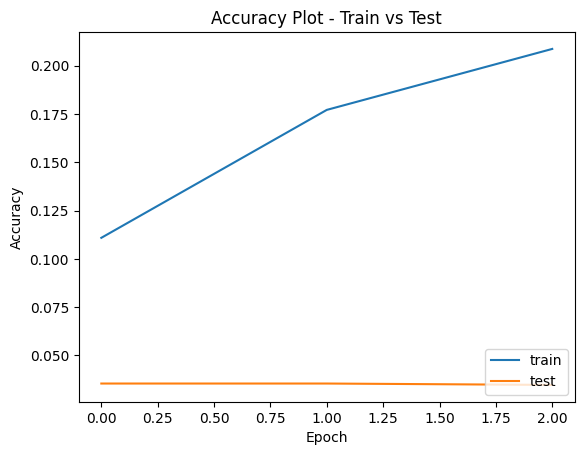

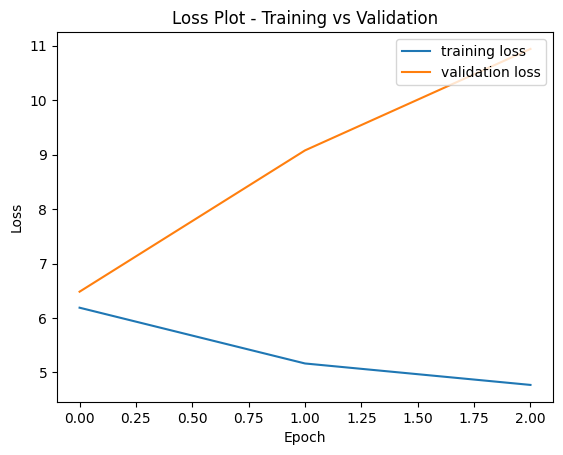

In [ ]:
# Graficamos la precisión del train frente a la del test
plt.plot(metrics['accuracy'])  # Graficamos la precisión del train
plt.plot(metrics['val_accuracy'])  # Graficamos la precisión del test
plt.legend(['train', 'test'], loc='lower right')
plt.title('Accuracy Plot - Train vs Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Graficamos la pérdida del entrenamiento junto con la del test
plt.plot(metrics['loss'])  # Representamos la pérdida del entrenameinto
plt.plot(metrics['val_loss'])  # Representamos la pérdida de la validación
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.title('Loss Plot - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

> **MEDIDAS DE EVALUACIÓN DEL MODELO**

In [ ]:
# Evaluación del modelo
evaluate_metrics = modelo.evaluate(X_test,y_cat_test,verbose=0)

# Mostramos los resultados de la evaluación
print("Evaluation Accuracy = {:.2f}%".format(evaluate_metrics[1] * 100))
print("Evaluation Loss = {:.6f}".format(evaluate_metrics[0]))

Evaluation Accuracy = 3.47%
Evaluation Loss = 10.940777


> **F-1 SCORE**

In [ ]:
# PREDICCIÓN
predictions = modelo.predict(X_test)

# Como nuestra capa de salida utiliza la activación softmax, las predicciones son probabilidades para cada clase.
# Para obtener la clase predicha, encuentra el índice de la probabilidad más alta para cada imagen
predicted_classes = np.argmax(predictions, axis=1)

# Ahora, podemos comparar las clases predichas con las clases reales (y_test) para evaluar el rendimiento del modelo.
# Imprime el informe de clasificación y la matriz de confusión para evaluar la precisión del modelo.
print(classification_report(np.argmax(y_cat_test, axis=1), predicted_classes))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
44/44 [==============================] - 3s 77ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        49
           6       0.04      1.00      0.07        48
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        50
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>  **CURVA ROC**

44/44 [==============================] - 3s 78ms/step


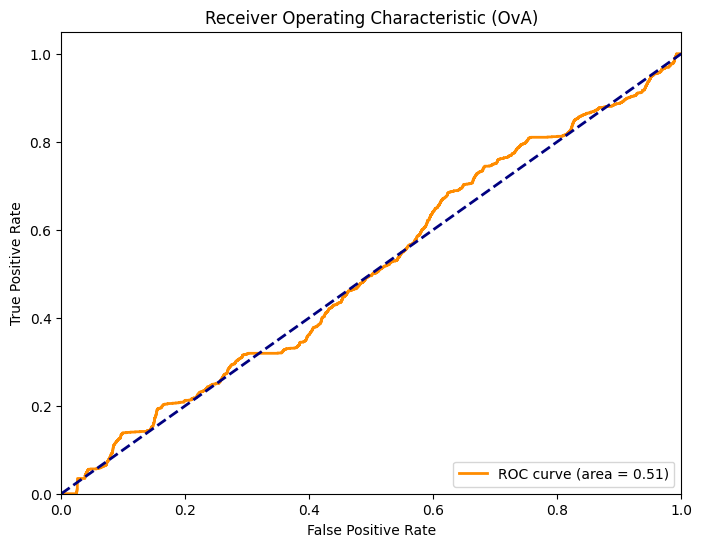

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Obtén las probabilidades predichas del modelo para el conjunto de prueba
y_score = modelo.predict(X_test)

# Binariza las etiquetas verdaderas
y_true_bin = label_binarize(y_test, classes=np.arange(29))

# Calcula la curva ROC agregada
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Configura el gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (OvA)')
plt.legend(loc="lower right")
plt.show()

>  **VISUALIZAR NUESTRO MODELO CONOCIENDO EL IoU DE CADA PREDICCIÓN**

In [ ]:
from tensorflow.keras.metrics import MeanIoU

1/1 [==============================] - 0s 17ms/step


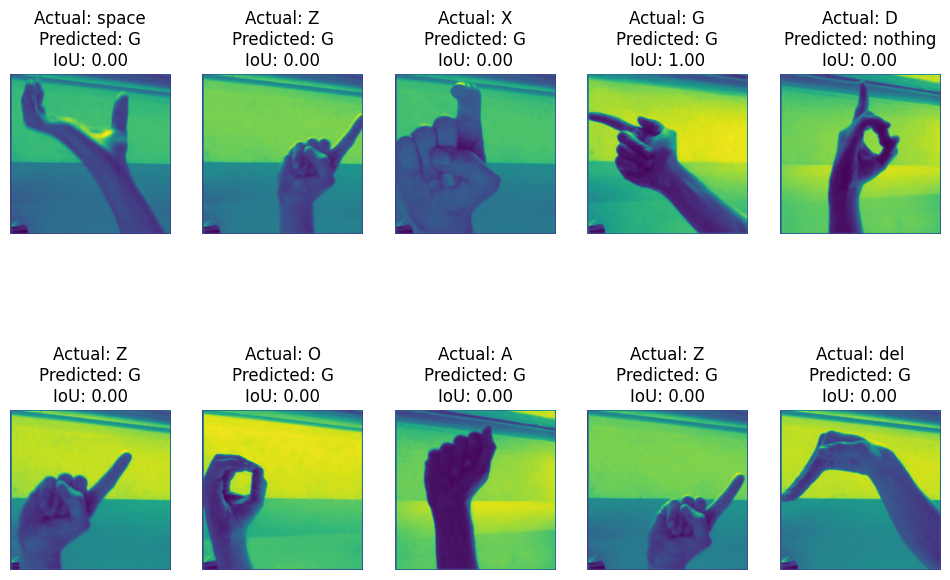

Valor final del IoU promedio: 0.10


In [ ]:
import random
import numpy as np

# Elegir un número de muestras para visualizar
num_samples = 10

# Crear listas para almacenar las predicciones y los IoU
predicted_classes = []
ious = []

# Crear un objeto MeanIoU para 29 clases (num_classes)
iou_metric = MeanIoU(num_classes=29)
# Para visualizar como de bien lo está haciendo mi modelo, podemos mostrar las imágenes de test con las predicciones de las clases.
# Elegimos imágenes aleatorias de test y sus clases correspodientes para visualizarlas.
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
          'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Visualizar algunas imágenes de prueba junto con las predicciones
plt.figure(figsize=(12, 8))

for i in range(num_samples):
    index = random.randint(0, len(X_test) - 1)

    # Obtener la imagen de prueba y su clase verdadera
    test_image = X_test[index]
    true_label = y_cat_test[index]  # Utilizar etiquetas one-hot encoded

    # Preparar la imagen para la predicción
    test_image = np.expand_dims(test_image, axis=0)

    # Realizar la predicción y obtener la clase predicha
    predicted_class = modelo.predict(test_image)
    predicted_class = np.argmax(predicted_class, axis=1)[0]
    predicted_class_one_hot = np.eye(29)[predicted_class]  # Convertir a one-hot encoded

    # Calcular el IoU para la clase predicha
    true_mask = (true_label == 1)
    pred_mask = (predicted_class_one_hot == 1)

    iou_value = np.sum(true_mask & pred_mask) / np.sum(true_mask | pred_mask)

    # Almacenar la predicción y el IoU
    predicted_classes.append(predicted_class_one_hot)
    ious.append(iou_value)

    # Mostrar la imagen con la clase verdadera, la clase predicha y el IoU
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {labels[np.argmax(true_label)]}\nPredicted: {labels[predicted_class]}\nIoU: {iou_value:.2f}")
    plt.axis('off')

plt.show()

# Obtener el valor final del IoU promediando sobre todas las predicciones
final_iou = np.mean(ious)
print(f'Valor final del IoU promedio: {final_iou:.2f}')


>  **MATRIZ DE CONFUSIÓN**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtén las clases predichas por el modelo para el conjunto de prueba
y_pred = np.argmax(modelo.predict(X_test), axis=1)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Normaliza la matriz de confusión para obtener la matriz de correlación
correlation_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

La matriz de confusión del modelo debería ser diagonal, para podre tomar el modelo como bueno.
A pesar de que haya valores fuera de la diagonal, se observa cierta tendencia a que los valores más altos sean los de la diagonal.
Se ve como en las dos esquinas en las que no se encuentra la diagonal, los valores son mínimos, del mismo modo que lo son los de su al rededor.

Tras haber realizado todas las métricas de evaluación, teniendo en cuenta el valor de la curva ROC (0,96) donde se ve que es un valor muy bueno aunque el modelo tiene sus errores ya que la esquina no es un ángulo recto; así como la F1 Score (0,48), el IoU (el promedio es de 0,6), y la matriz de confusión, podemos concluir con que nuestro modelo es correcto y que por lo tanto lo podemos dar como válido.